In [ ]:
from __future__ import annotations
import inspect
from typing import *
from etils.lazy_imports import *

In [ ]:
class MyConfig(Config):
    model_name: str
    batch_size: int

    @config_property
    def learning_rate(self) -> float:
        return self.batch_size * 3

### Descriptors

In [54]:
class Descriptor:

    def __get__(self, obj, obj_cls):
        print(f'Descriptor.__get__({obj}, {obj_cls.__name__})')


class A:
    x = Descriptor()


a = A()
a

In [55]:
A.x
a.x

Descriptor.__get__(None, A)
Descriptor.__get__(<__main__.A object at 0x120cc14e0>, A)


In [56]:
class A:
    
    @staticmethod
    def create():
        return A()

    @property
    def x(self):
        return 1

In [57]:
class A:
    
    create = staticmethod(lambda: A())

    x = property(lambda self: 1)

a = A()

In [58]:
print(A.create)
print(a.create)

<function A.<lambda> at 0x120d04550>
<function A.<lambda> at 0x120d04550>


In [60]:
descriptor = A.__dict__['create']
descriptor

<staticmethod(<function A.<lambda> at 0x120d04550>)>

In [61]:
print(descriptor.__get__(None, A))
print(descriptor.__get__(a, A))

<function A.<lambda> at 0x120d04550>
<function A.<lambda> at 0x120d04550>


In [63]:
print(A.x)
print(a.x)

1


In [62]:
descriptor = A.__dict__['x']

print(descriptor.__get__(None, A))
print(descriptor.__get__(a, A))

1


In [64]:
class A:

    def fn(self):
        pass

a = A()


print(A.fn)
print(a.fn)

<function A.fn at 0x120d04940>
<bound method A.fn of <__main__.A object at 0x120cc2cb0>>


In [65]:
fn = A.__dict__['fn']

print(fn.__get__(None, A))
print(fn.__get__(a, A))

<function A.fn at 0x120d04940>
<bound method A.fn of <__main__.A object at 0x120cc2cb0>>


In [66]:
def fn(self=None):
    print(f'fn({self=})')


class A:
    fn1 = fn
    fn2 = functools.partial(fn)


a = A()
a.fn1()
a.fn2()

fn(self=<__main__.A object at 0x120cc1150>)
fn(self=None)


In [67]:
print(a.fn1)
print(a.fn2)

<bound method fn of <__main__.A object at 0x120cc1150>>
functools.partial(<function fn at 0x120d04ca0>)


In [68]:
fn1 = A.__dict__['fn1']
fn1 = fn1.__get__(a, A)
fn1()

fn2 = A.__dict__['fn2']
fn2()

fn(self=<__main__.A object at 0x120cc1150>)
fn(self=None)


In [69]:
class Descriptor:

    def __set_name__(self, obj_cls, name):
        print(f'__set_name__({obj_cls.__name__}, {name!r})')

    def __get__(self, obj, obj_cls):
        print(f'Descriptor.__get__({obj}, {obj_cls})')

    def __set__(self, obj, value):
        print(f'Descriptor.__set__({obj}, {value})')

In [72]:
class A:
    x = Descriptor()
    y = Descriptor()

__set_name__(A, 'x')
__set_name__(A, 'y')


In [73]:
class Descriptor:

    def __set_name__(self, obj_cls, name):
        self.name = name
        self.type_hint = typing.get_type_hints(obj_cls)[name]

    # def __get__(self, obj, obj_cls):
    #     pass

    def __set__(self, obj, value):
        if not isinstance(value, self.type_hint):
            raise TypeError(f'Expected {self.name} to be {self.type_hint}. Got {type(value)}')
        obj.__dict__[self.name] = value


class A:
    x: int = Descriptor()
    y: str = Descriptor()

a = A()
a.x = 123
a.y = 'abc'

In [74]:
a.x = 'abc'

TypeError: Expected x to be <class 'int'>. Got <class 'str'>

In [86]:
def my_dataclass(obj_cls):
    attr_names = list(typing.get_type_hints(obj_cls))
    for attr_name in attr_names:
        descriptor = Descriptor()
        descriptor.__set_name__(obj_cls, attr_name)
        setattr(obj_cls, attr_name, descriptor)

    obj_cls.__init__ = make_init(attr_names)
    obj_cls.__repr__ = make_repr(attr_names)
    return obj_cls

@my_dataclass
class A:
    x: int
    y: str | float


a = A(1, 2.)
# a.x = '123'
a

A(x=1, y=2.0)

### inspect.Signature

In [77]:
signature = inspect.Signature([
    inspect.Parameter('x', kind=inspect.Parameter.POSITIONAL_OR_KEYWORD),
    inspect.Parameter('y', kind=inspect.Parameter.POSITIONAL_OR_KEYWORD),
    inspect.Parameter('z', kind=inspect.Parameter.KEYWORD_ONLY, default=None),
])

print(signature)

(x, y, *, z=None)


In [80]:
b = signature.bind(1, 4, w=2)
b

TypeError: got an unexpected keyword argument 'w'

In [81]:
def make_init(attr_names):
    params = [
        inspect.Parameter(name, kind=inspect.Parameter.POSITIONAL_OR_KEYWORD)
        for name in attr_names
    ]
    signature = inspect.Signature(params)
    

    def __init__(self, *args, **kwargs):
        bound_arguments = signature.bind(*args, **kwargs)
        for k, v in bound_arguments.arguments.items():
            setattr(self, k, v)

    return __init__


def make_repr(attr_names):
    def __repr__(self):
        attr_str = [f'{name}={getattr(self, name)!r}' for name in attr_names]
        attr_str = ', '.join(attr_str)
        return f'{self.__class__.__qualname__}({attr_str})'
    return __repr__



### `__init_subclass__`

In [94]:
class Dataset:
    subclasses = []

    def __init_subclass__(cls, **kwargs):
        cls.subclasses.append(cls)
        super().__init_subclass__(**kwargs)


class Mnist(Dataset):
    pass


class Cifar(Dataset):
    pass


class Imagenet(Dataset):
    pass


Dataset.subclasses

[__main__.Mnist, __main__.Cifar, __main__.Imagenet]

In [95]:
class Dataset:
    subclasses = []

    def __init_subclass__(cls, skip=False, **kwargs):
        if not skip:
            cls.subclasses.append(cls)
        super().__init_subclass__(**kwargs)


class Mnist(Dataset):
    pass


class Cifar(Dataset):
    pass


class Imagenet(Dataset, skip=True):
    pass


Dataset.subclasses

[__main__.Mnist, __main__.Cifar]

### `__new__`

In [96]:
class A:
    pass

A()

In [97]:
class B:
    pass


class A:

    def __new__(cls, x):
        return B()

    def __init__(self, x):
        pass

A(x=1)

In [98]:
A.__new__(A, x=1)

In [ ]:
args = ()
kwargs = {'x': 1}

a = A.__new__(A, *args, **kwargs)
if (
    isinstance(a, A)
    and type(a).__init__ is not object.__init__
):
    a.__init__(*args, **kwargs)
a

In [104]:
class Dataset:
    subclasses = {}

    def __init_subclass__(cls, **kwargs):
        cls.subclasses[cls.__name__.lower()] = cls

        csl.__init__
        super().__init_subclass__(**kwargs)

    def __new__(cls, name):
        if cls is Dataset:
            cls = cls.subclasses[name.lower()]

        self = super().__new__(cls)
        self.internal = True
        return self

    def __init__(self):
        super().__init__()

class Mnist(Dataset):

    def __init__(self):
        super().__init__()


class Cifar(Dataset):
    pass


class Imagenet(Dataset):
    pass



mnist = Dataset('mnist')
mnist

### Metaclass

In [105]:
class A:
    pass

a = A()

In [106]:
type(a)

__main__.A

In [108]:
type(A)

type

In [109]:
print(type('abc'))
print(type(123))
print(type(True))
print(type(a))

print()

print(type(str))
print(type(int))
print(type(bool))
print(type(A))

<class 'str'>
<class 'int'>
<class 'bool'>
<class '__main__.A'>

<class 'type'>
<class 'type'>
<class 'type'>
<class 'type'>


In [110]:
print(type(type))

<class 'type'>


In [ ]:
a = A()

In [111]:
A = type('A', (), {})  # class_name, bases, attributes dict

A()

In [112]:
class MetaA(type):
    pass

class A(metaclass=MetaA):
    pass

a = A()

In [113]:
type(a)

__main__.A

In [114]:
type(A)

__main__.MetaA

In [115]:
A = MetaA('A', (), {})

A()

In [120]:
class MetaA:  # (type):

    def __repr__(self):
        return 'MetaA()'

class A(MetaA): # (metaclass=MetaA):

    def __repr__(self):
        return 'A()'

a = A()

In [121]:
repr(a)

'A()'

In [122]:
repr(A)

"<class '__main__.A'>"

In [ ]:
class MetaA(type):

    def __add__(self, other):
        return MetaA(f'{self.__name__}{other.__name__}', (self, other), {})

    # def __add__(self, other):
    #     return MetaA(f'{self.}', (self, other), {})


class A(metaclass=MetaA):
    x = 1

    def fn(self):
        return f'{type(self).__name__}.fn'


class B:
    y = 2

C = A + B

In [131]:
class MetaA(type):

    def __add__(self, other):
        return MetaA(f'{self.__name__}{other.__name__}', (self, other), {})

    def __getitem__(self, key):
        return self


class A: # (metaclass=MetaA):
    x = 1

    def __class_getitem__(self, key):
        return self


    def fn(self):
        return f'{type(self).__name__}.fn'


class B:
    y = 2

# C = A + B

A[int]

__main__.A

In [130]:
A[int]

__main__.A

In [128]:
c = C()
c.y

2

In [132]:
class MetaA(type):

    def _repr_html_(self):
        return 'This is a <a href="#link">MetaA()</a>'


class A(metaclass=MetaA):

    def _repr_html_(self):
        return 'This is <a href="#link">a A()</a>'


a = A()
a

In [133]:
A

__main__.A

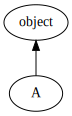

In [10]:
import graphviz
        
def _build_graph(dot, obj: type):
    for parent in obj.__bases__:
        dot.edge(parent.__name__, obj.__name__, dir='back')
        _build_graph(dot, parent)

def _make_graph(obj: type):
    dot = graphviz.Digraph(strict=True)
    dot.node(obj.__name__)
    _build_graph(dot, obj)
    return dot


class MetaGraph(type):

    def __pos__(self):
        return _make_graph(self)


class A(metaclass=MetaGraph):
    pass

+A

### Method resolution order

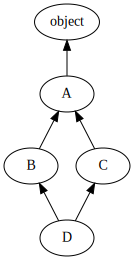

In [141]:
class A(metaclass=MetaGraph):
    def __init__(self):
        print('A')
        super().__init__()

class B(A):
    def __init__(self):
        print('B')
        super().__init__()
        print('end B')

class C(A):
    def __init__(self):
        print('C')
        super().__init__()

class D(B, C):
    def __init__(self):
        print('D')
        super().__init__()

+D

In [140]:
D()

D
B
C
A


In [142]:
D.mro()

[__main__.D, __main__.B, __main__.C, __main__.A, object]

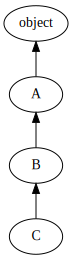

In [143]:
class A(metaclass=MetaGraph):
    def __init__(self):
        print('A')
        super().__init__()

class B(A):
    def __init__(self):
        print('B')
        super().__init__()

class C(B):
    def __init__(self):
        print('C')
        super().__init__()

+C

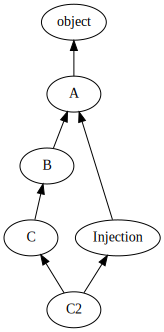

In [144]:
class Injection(A):
    def __init__(self):
        print('Injection')
        super().__init__()


class C2(C, Injection):
    def __init__(self):
        print('C2')
        super().__init__()

+C2

In [145]:
C2()

C2
C
B
Injection
A


In [146]:
D.mro()

[__main__.D, __main__.B, __main__.C, __main__.A, object]

In [14]:
class Validator(metaclass=MetaGraph):

    def __init__(self, value):
        self.value = value
        super().__init__()


class IsPositive(Validator):

    def __init__(self, value):
        assert value > 0, 'Is not positive'
        super().__init__(value = value)


class IsEven(Validator):

    def __init__(self, value):
        assert value % 2 == 0, 'Is not even'
        super().__init__(value = value)


class PositiveAndEven(IsPositive, IsEven):
    pass


# PositiveAndEven(3)

AssertionError: Is not even

In [ ]:
F.mro()

In [ ]:
D()

In [ ]:
class A:
    
    def __init__(self, x):
        self.x = x

    def __repr__(self):
        return f'A(x={self.x})'

In [ ]:
a = A(x=1)
a

### for ... else ...

In [151]:
def find_number(x):
    for i in range(10):
        if x == i:
            break
    nobreaks:  # No break
        print(f'{x} not found')

find_number(3)
find_number(18)

18 not found


### `@contextlib.contextmanager`

In [7]:
@contextlib.contextmanager
def my_context():
    print('Enter')
    try:
        yield
    finally:
        print('Exit')

NameError: name 'contextlib' is not defined

In [153]:
with my_context():
    print('Inside')

Enter
Inside
Exit


In [154]:
@my_context()
def fn():
    print('Inside')

fn()

Enter
Inside
Exit


### UserDict

In [155]:
class LowerDict(dict):

    def __setitem__(self, k, v):
        super().__setitem__(k.lower(), v)


d = LowerDict(MY_ATTR=1, Other_Attr=2)
d.update(A_TEST=3)
d['SOME_TEST'] = 4
d

{'MY_ATTR': 1, 'Other_Attr': 2, 'A_TEST': 3, 'some_test': 4}

In [156]:
class LowerDict(collections.abc.MutableMapping):

    def __setitem__(self, k, v):
        super().__setitem__(k.lower(), v)

LowerDict()

TypeError: Can't instantiate abstract class LowerDict with abstract methods __delitem__, __getitem__, __iter__, __len__

In [157]:
class LowerDict(collections.UserDict):

    def __setitem__(self, k, v):
        super().__setitem__(k.lower(), v)


d = LowerDict(MY_ATTR=1, Other_Attr=2)
d.update(A_TEST=3)
d['SOME_TEST'] = 4
d

{'my_attr': 1, 'other_attr': 2, 'a_test': 3, 'some_test': 4}

### Dedent

In [ ]:
if True:
    msgs = dict(
        x=1,
        y="""
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer nec 
odio. Praesent libero. Sed cursus ante dapibus diam. Sed nisi. Nulla 
quis sem at nibh elementum imperdiet. Duis sagittis ipsum. Praesent 
mauris. Fusce nec tellus sed augue semper porta. Mauris massa.
""",
        z=2,
    )

In [ ]:
if True:
    msgs = dict(
        x=1,
        y=textwrap.dedent("""
        Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer nec 
        odio. Praesent libero. Sed cursus ante dapibus diam. Sed nisi. Nulla 
        quis sem at nibh elementum imperdiet. Duis sagittis ipsum. Praesent 
        mauris. Fusce nec tellus sed augue semper porta. Mauris massa.
        """),
        z=2,
    )

### SimpleNamespace

In [159]:
ns = types.SimpleNamespace(
    x=1,
    y=2,
    z=3,
)

ns.w = 5
ns.x

1

## Py 3.8, 3.9

### Better debug messages

In [ ]:
x = 1

f'New debug string `{x=}`. Anoter example: `{1 + 3=}`'

### Walrus operator

In [ ]:


x = find_something()
if x:
    print(x)

In [ ]:
if x := find_something():
    print(x)

In [6]:
fn = lambda: (
    x := 1,
    y := x + 4,
    b := (x, y),
) and b

fn()

(1, 5)

### Structural Pattern Matching

In [ ]:
x = bool

match x:
  # values
  case 0:
    print('case 0')
  case 1:
    print('case 1')
  case 'abc':
    print('case "abc"')

  # types
  case bool():
    print('case bool')

  case type(bool()):
    print('case bool')

  case _:
    print('Default')

In [ ]:
x = 1

match x:
  case int():
    print('a', z)
  case str():
    print('b')

In [ ]:
x = dict(
    x=1,
    y=2,
    z=3,
)

class Point:

  def __init__(self, x=1, y=2):
    self.x = y
    self.y = x

  def __getattr__(self, key):
    print(key)
    return 123

  @property
  def z(self):
    print('z')
    return 'acv'

x = Point()

match x:
  case Point(x=a, z=b, i=123 as z):
    print('PPP', a, b, z)
  case {'x': a}:
    print('a', a)
  case str():
    print('b')
  case _:
    raise ValueError

## Toml & config

### Tomllib

TOML:

```toml
[build-system]
requires = ["setuptools", "wheel"]  # PEP 508 specifications.
```

Json:

```json
{
    "build": {
        "requires": ["setuptools", "wheel>=0.27"]
    }
}
```

YAML:

```yaml
build:
    requires:
        - setuptools
        - wheel>=0.27
```


```toml
title = "TOML Example"

[owner]
name = "Tom Preston-Werner"
dob = 1979-05-27T07:32:00-08:00 # First class dates

[database]
server = "192.168.1.1"
ports = [ 8000, 8001, 8002 ]
connection_max = 5000
enabled = true
```

### `pyproject.toml`

## Typing annotations

### Type unions

### Protocol

### TypeGuard

### Self

In [ ]:
@dataclasses.dataclass
class A:
    x: int

    @classmethod
    def create(cls) -> Self:
        return cls(x=0)
    
    def replace(self, x) -> Self:
        return dataclasses.replace(self, x=x)


class B(A):
    pass


b = B.create()
b.replace(x=3)

### Literal

### Variadic Generics

### Type Alias

### Final

### TypedDict